<a href="https://colab.research.google.com/github/RVS97/MNIST-GANs/blob/master/TCV2_cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries
Import required libraries

In [0]:
import sys
import json
import os
import glob
import tensorflow.python.keras
from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape, Add
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose 
from tensorflow.python.keras.layers import Input, UpSampling2D, concatenate  
from tensorflow.python.keras.layers import LeakyReLU
from tensorflow.python.keras.layers.merge import concatenate
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from sklearn.utils import shuffle
from matplotlib import pyplot
import datetime
import pickle

# Dataset
Import MNIST dataset from keras and map image values to 0/1

In [0]:
# Import dataset
from keras.datasets import mnist

class MNISTdata:
  def __init__(self, batchSize=100, shuffle=True):

    # Load into variables
    (self.x_train, self.y_train),(self.x_test, self.y_test) = mnist.load_data()
    
    self.x_train = np.expand_dims(self.x_train, -1)
    self.x_test = np.expand_dims(self.x_test, -1)
    
    # One-hot encode labels
    self.y_train = to_categorical(self.y_train, num_classes=10)
    self.y_test = to_categorical(self.y_test, num_classes=10)
    
    # Map image values to the range -1/1
    self.x_train = (self.x_train.astype(np.float32) - 127.5)/127.5*-1
    self.x_test = (self.x_test.astype(np.float32) - 127.5)/127.5*-1#R
    #self.x_train, self.x_test = self.x_train/255.0, self.x_test/255.0

    self.imgWidth = len(self.x_train[0][0])
    self.imgHeight = len(self.x_train[0])
    self.nTrainSamples = len(self.x_train)
    self.nTestSamples = len(self.x_test)
    
    print("MNIST loaded correctly")
    print(" - {} by {} images (grayscale)".format(self.imgWidth,self.imgHeight))
    print(" - {} training samples".format(self.nTrainSamples))
    print(" - {} test samples".format(self.nTestSamples))
    
    self.batchSize = batchSize
    self.nBatches = int(self.nTrainSamples/self.batchSize)
    
    print("Batch size {} -> {} batches".format(self.batchSize, self.nBatches))
    
    if shuffle: self.shuffleData()
  
  def shuffleData(self):
    self.x_train, self.y_train = shuffle(self.x_train, self.y_train)
    
  def getBatch(self, batchId):
    return self.x_train[batchId*self.batchSize:(batchId+1)*self.batchSize], self.y_train[batchId*self.batchSize:(batchId+1)*self.batchSize]
    
data = MNISTdata(batchSize=200)

Using TensorFlow backend.


11493376/11490434 [==============================] - 2s 0us/step
MNIST loaded correctly
 - 28 by 28 images (grayscale)
 - 60000 training samples
 - 10000 test samples
Batch size 200 -> 300 batches


# Model Data

In [0]:
class modelData:
  def __init__(self, model, modelId='auto'):
    # Save model structure
    self.jsonStructure = model.to_json()
    
    # Set model id (defaut is timestamp of creation)
    if modelId == 'auto':
      self.modelId = self.setId()
    else:
      self.modelId = modelId
    
    # Set saved epoch counter to 0
    self.currentEpoch = 0
    self.epochsHist = {}
    
    self.params = {}
    
  def setId(self):
    return datetime.datetime.now().strftime("%d_%Hh_%Mm")
  
  def getId(self):
    return self.modelId
  
  def addEpochCheckpoint(self, model, hist):
    # Save weights
    self.currentEpoch += 1
    
    # Save history
    self.epochsHist[self.currentEpoch] = hist.history
    
    # Save model
    saveName = self.modelId + "_" + model.name + "_" + str(self.currentEpoch) + ".h5"
    model.save(saveName)
    return saveName
  
  def saveParams(self, **params):
    self.params.update(params)

# Google Drive Mount


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
rootDir = "/content/rootDir"

def saveFile(filePath, rootDir):
  !cp $filePath $rootDir
  
def getFile(fileName, rootDir, localDir = "./"):
  path = rootDir + "/" + fileName
  !cp $path $localDir

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Generator and Discriminator
Define generator and discriminator network

In [0]:
def getDiscriminator(imageInputShape=(28,28,1), labelInputShape=(10,)):
  # Model for image input
  modelImageIn = Input(shape=imageInputShape)
  x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer='glorot_uniform')(modelImageIn)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization(axis=-1)(x)
  modelImage = Model(modelImageIn, x)
  
  # Model for label input
  modelLabelIn = Input(shape=labelInputShape)
  y = Dense(14*14*32, activation='relu', name='InputDenseb', kernel_initializer='glorot_uniform')(modelLabelIn)
  y = BatchNormalization(axis=-1)(y)
  y = Reshape((14, 14, 32), name='InputReshapeb')(y)
  
#   y = Conv2D(64, (3, 3), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer='glorot_uniform')(y)
#   y = BatchNormalization(axis=-1)(y)
  modelLabel = Model(modelLabelIn, y)
  
  # Merged
  concat = concatenate([x, y])
  out = Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer='glorot_uniform')(concat)
  out = LeakyReLU(alpha=0.2)(out)
  out = BatchNormalization(axis=-1)(out)
  
  out = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer='glorot_uniform')(out)
  out = LeakyReLU(alpha=0.2)(out)
  out = BatchNormalization(axis=-1)(out)
  
  out = Flatten()(out)
  out = Dense(1, activation='sigmoid')(out)
  
  mergedModel = Model([modelImageIn, modelLabelIn], out, name="Discriminator")
  
  return mergedModel



def getDiscriminator2(imageInputShape=(28,28,1), labelInputShape=(10,)):
  # Model for image input
  modelImageIn = Input(shape=imageInputShape)
  x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer='glorot_uniform')(modelImageIn)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization(axis=-1)(x)
  modelImage = Model(modelImageIn, x)
  
  # Model for label input
  modelLabelIn = Input(shape=labelInputShape)
  y = Dense(14*14*32, activation='relu', name='InputDenseb', kernel_initializer='glorot_uniform')(modelLabelIn)
  y = BatchNormalization(axis=-1)(y)
  y = Reshape((14, 14, 32), name='InputReshapeb')(y)
  
#   y = Conv2D(64, (3, 3), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer='glorot_uniform')(y)
#   y = BatchNormalization(axis=-1)(y)
  modelLabel = Model(modelLabelIn, y)
  
  # Merged
  concat = concatenate([x, y])
  out = Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer='glorot_uniform')(concat)
  out = LeakyReLU(alpha=0.2)(out)
  out = BatchNormalization(axis=-1)(out)
  
  out = Flatten()(out)
  out = Dense(1, activation='sigmoid')(out)
  
  mergedModel = Model([modelImageIn, modelLabelIn], out, name="Discriminator")
  
  return mergedModel

In [0]:
def getGenerator(noiseInputShape=(100,), labelInputShape=(10,)):
  # Model for noise input
  modelNoiseIn = Input(shape=noiseInputShape)
  x = Dense(7*7*256, activation='relu', name='InputDense', kernel_initializer='glorot_uniform')(modelNoiseIn)
  x = BatchNormalization(axis=-1)(x)
  x = Reshape((7, 7, 256), name='InputReshape')(x)
  
#   x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu', name='tConv1', kernel_initializer='glorot_uniform')(x)
#   x = BatchNormalization(axis=-1)(x)
  modelNoise = Model(modelNoiseIn, x)
  
  # Model for label input
  modelLabelIn = Input(shape=labelInputShape)
  y = Dense(7*7*256, activation='relu', name='InputDenseb', kernel_initializer='glorot_uniform')(modelLabelIn)
  y = BatchNormalization(axis=-1)(y)
  y = Reshape((7, 7, 256), name='InputReshapeb')(y)
  
#   y = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu', name='tConv1b', kernel_initializer='glorot_uniform')(y)
#   y = BatchNormalization(axis=-1)(y)
  modelLabel = Model(modelLabelIn, y)
  
  # Concatenation layer
  concat = concatenate([x, y])
  
  out = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu', name='tConv1', kernel_initializer='glorot_uniform')(concat)
  out = BatchNormalization(axis=-1)(out)
  
  out = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu', name='tConv2b', kernel_initializer='glorot_uniform')(out)
  out = BatchNormalization(axis=-1)(out)
  
  out = Conv2D(1, (3, 3), padding='same', activation='tanh', name='outConvb', kernel_initializer='glorot_uniform')(out)
  
  mergedModel = Model([modelNoiseIn, modelLabelIn], out, name="Generator")
  
  return mergedModel

def getGenerator2(noiseInputShape=(100,), labelInputShape=(10,)):
  # Model for noise input
  modelNoiseIn = Input(shape=noiseInputShape)
  x = Dense(7*7*128, activation='relu', name='InputDense', kernel_initializer='glorot_uniform')(modelNoiseIn)
  x = BatchNormalization(axis=-1)(x)
  x = Reshape((7, 7, 128), name='InputReshape')(x)
  
#   x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu', name='tConv1', kernel_initializer='glorot_uniform')(x)
#   x = BatchNormalization(axis=-1)(x)
  modelNoise = Model(modelNoiseIn, x)
  
  # Model for label input
  modelLabelIn = Input(shape=labelInputShape)
  y = Dense(7*7*128, activation='relu', name='InputDenseb', kernel_initializer='glorot_uniform')(modelLabelIn)
  y = BatchNormalization(axis=-1)(y)
  y = Reshape((7, 7, 128), name='InputReshapeb')(y)
  
#   y = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu', name='tConv1b', kernel_initializer='glorot_uniform')(y)
#   y = BatchNormalization(axis=-1)(y)
  modelLabel = Model(modelLabelIn, y)
  
  # Concatenation layer
  concat = concatenate([x, y])
  
  out = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu', name='tConv1', kernel_initializer='glorot_uniform')(concat)
  out = BatchNormalization(axis=-1)(out)
  
  out = Conv2D(1, (3, 3), padding='same', activation='tanh', name='outConvb', kernel_initializer='glorot_uniform')(out)
  
  mergedModel = Model([modelNoiseIn, modelLabelIn], out, name="Generator")
  
  return mergedModel

In [0]:
def getNoise(size):
    return np.random.normal(size=size), to_categorical(np.random.randint(0,10,(1,size[0])), num_classes=10)[0]

In [0]:
def trainDiscriminator(model, data, labels):
  # Reset optmizer state?
  
  # Return loss
  return model.fit(x=data, y=labels, verbose=0)

In [0]:
def trainGenerator(model, fakeData, labels):
  # Reset optimizer state?
  
  # Classify data with discriminator model
  loss = model.fit(x=fakeData, y=labels, verbose=0)
  
  return loss
  

# Training

In [0]:
class paramSearch:
  def  __init__(self, K, optTypes, learnRate, beta1):
    self.K = K
    self.optTypes = optTypes
    self.learnRate = learnRate
    self.beta1 = beta1
    
  def getParams(self):
    for k in self.K:
      for opt in self.optTypes:
        if opt == 'sgd':
          for lr in self.learnRate:
            yield k, opt, lr
        else:
          for b1 in self.beta1:
            yield k, opt, b1

In [0]:
noiseVecLength = 100

# pS = paramSearch(K=[1, 2, 3], optTypes=['sgd', 'adam'], learnRate=[0.0001, 0.00001], beta1=[0.5, 0.9])
pS = paramSearch(K=[1, 2, 3], optTypes=['adam'], learnRate=[0.1], beta1=[0.5, 0.9])
pS = paramSearch(K=[1], optTypes=['adam'], learnRate=[0.1], beta1=[0.5])
for k, opt, param in pS.getParams():
  epochs = 3
  
  # Redefine models to clear
  disc = getDiscriminator()
  discData = modelData(disc)
  
  # Get generator
  gen = getGenerator()
  
  # Get complete GAN
  noiseInput = Input(shape=(100,))
  labelInput = Input(shape=(10,))

  genGAN = gen([noiseInput, labelInput])
  out = disc([genGAN, labelInput])
  gan = Model([noiseInput, labelInput], out, name="gan")
  ganData = modelData(gan, modelId=discData.getId())
  
  # Save K
  K = k
  discData.saveParams(K=K)
  
  # Specify and save optimiser
  optimiser = Adam(lr=0.0002, beta_1=param, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  discData.saveParams(optType='adam', opt=optimiser.get_config())

  # Compile models
  disc.compile(optimizer=optimiser, loss='binary_crossentropy')
  discData.saveParams(loss=disc.loss)
  
  gan.layers[-1].trainable=False # Lock discriminator
  gan.compile(optimizer=optimiser, loss='binary_crossentropy')
  ganData.saveParams(loss=gan.loss)
  
  # Create folder where to save model
  subDir = rootDir + "/" + discData.getId()
  !mkdir $subDir
  
  # Train
  for e in range(epochs):
    print(str(e))
    
    # Shuffle batches
    data.shuffleData()
    
    # Iterations
    for iter in range(data.nBatches):
      for k in range(K):
        # Get real data
        realImages, realLabels = data.getBatch(iter)

        # Get fake data
        noiseInput, noiseLabels = getNoise((data.batchSize, noiseVecLength))
#         print(noiseInput.shape)
#         print(noiseLabels.shape)
#         print(data.batchSize)
        fakeImages = gen.predict([noiseInput, noiseLabels], batch_size=data.batchSize)
        fakeLabels = np.zeros((data.batchSize,))

#         histDisc = trainDiscriminator(disc, [realImages, realLabels], np.ones((data.batchSize,)))
#         histDisc2 = trainDiscriminator(disc, [fakeImages, noiseLabels], fakeLabels)
        # Train discriminator
        allImages = np.concatenate((realImages, fakeImages))
        classLabels = np.concatenate((realLabels, noiseLabels))                        # 0 to 9 to specify class
        discriminatorLabels = np.concatenate((np.ones((data.batchSize,)), fakeLabels)) # 0 or 1 to determine if fake or real
        histDisc = trainDiscriminator(disc, [allImages, classLabels], discriminatorLabels)
        
      # Train generator
      noiseInput, noiseLabels = getNoise((data.batchSize, noiseVecLength))
      fakeLabels = np.ones((data.batchSize,))
      histGan = trainGenerator(gan, [noiseInput, noiseLabels], fakeLabels)

      if iter%200 == 0:
        print("Discriminator: {}  Generator: {}".format(histDisc.history['loss'], histGan.history['loss']))
        
    # Save discriminator
    savedDiscName = discData.addEpochCheckpoint(disc, histDisc)
    discDataName = discData.getId() + "_" + disc.name + "_data.pkl"
    with open(discDataName, 'wb') as f:
      pickle.dump(discData, f)

    saveFile(savedDiscName, subDir)
    saveFile(discDataName, subDir)

    # Save gan
    savedGanName = ganData.addEpochCheckpoint(gan, histGan)
    ganDataName = ganData.getId() + "_" + gan.name + "_data.pkl"
    with open(ganDataName, 'wb') as f:
      pickle.dump(ganData, f)

    saveFile(savedGanName, subDir)
    saveFile(ganDataName, subDir)

In [0]:
print(realImages.shape)
print(fakeImages.shape)
print(allImages.shape)

(200, 28, 28, 1)
(200, 28, 28, 1)
(400, 28, 28, 1)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
InputDense (Dense)              (None, 12544)        1266944     input_21[0][0]                   
__________________________________________________________________________________________________
InputDenseb (Dense)             (None, 12544)        137984      input_22[0][0]                   
__________________________________________________________________________________________________
batch_norm

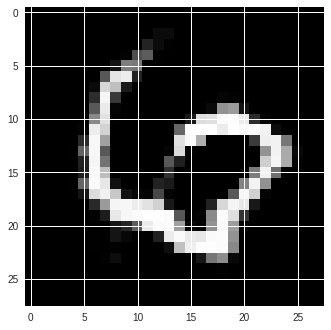

In [0]:
disc = getDiscriminator()
#adam = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #R
gen = getGenerator()
gen.summary()
#gen.compile(optimizer=adam, loss='binary_crossentropy') #R
#disc.compile(optimizer=adam, loss='binary_crossentropy') #R

noiseInput = Input(shape=(100,))
labelInput = Input(shape=(10,))

genGAN = gen([noiseInput, labelInput])
out = disc([genGAN, labelInput])
gan = Model([noiseInput, labelInput], out)
gan.summary()
# descGan = disc
# gan = disc
# gan = Model([(100,), (10,)])
# gan.add(gen)
# gan.add(disc)
# gan.summary()

epochs = 3
K = 1
noiseVecLength = 100

adam = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

disc.compile(optimizer=adam, loss='binary_crossentropy')

gan.layers[-1].trainable=False
gan.compile(optimizer=adam, loss='binary_crossentropy')
gan.layers[-1].trainable=True #R
for e in range(epochs):
  print(str(e))
  data.shuffleData()
  for iter in range(data.nBatches):
    for k in range(K):
      # Get real data
      realImages, realLabels = data.getBatch(iter)
      
      #realLabels = y_train[batchIdxs]

      noiseInput, noiseLabels = getNoise((data.batchSize, noiseVecLength))
      
      fakeImages = gen.predict([noiseInput, noiseLabels], batch_size=data.batchSize)
      fakeLabels = np.zeros((data.batchSize,))
      
      histDisc1 = trainDiscriminator(disc, [realImages, realLabels], np.ones((data.batchSize,)))
      histDisc2 = trainDiscriminator(disc, [fakeImages, noiseLabels], fakeLabels)
      
      pyplot.imshow(np.squeeze(fakeImages[0]))
      
    noiseInput, noiseLabels = getNoise((data.batchSize, noiseVecLength))
    fakeLabels = np.ones((data.batchSize,))
    
    gan.layers[-1].trainable=False #R
    histGen = trainGenerator(gan, [noiseInput, noiseLabels], fakeLabels)
    gan.layers[-1].trainable=True #R
    
    if iter%200 == 0:
      print("Discriminator: {}, {}  Generator: {}".format(histDisc1.history['loss'], histDisc2.history['loss'], histGen.history['loss']))

In [0]:
gan.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_103 (InputLayer)          (None, 100)          0                                            
__________________________________________________________________________________________________
input_104 (InputLayer)          (None, 10)           0                                            
__________________________________________________________________________________________________
model_117 (Model)               (None, 28, 28, 1)    2170369     input_103[0][0]                  
                                                                 input_104[0][0]                  
__________________________________________________________________________________________________
Discriminator (Model)           (None, 1)            506497      model_117[1][0]                  
          

In [0]:
noiseLabels = to_categorical(np.ones(data.batchSize), num_classes=10)


In [0]:
tag = "06_22h_18m"
getFile(tag + "_gan_5.h5", rootDir + "/" + tag)

In [0]:
gan.set_weights(keras.models.load_model(tag + "_gan_5.h5").get_weights())

In [0]:
noiseInput, noiseLabels = getNoise((data.batchSize, noiseVecLength))
noiseLabels = to_categorical(np.ones(data.batchSize)*5, num_classes=10) # multiply times label
fakeImages = gen.predict([noiseInput, noiseLabels], batch_size=data.batchSize)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


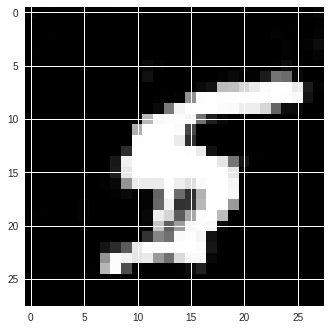

In [0]:
# Check example generated digit for given (above) label
id = 12
print(noiseLabels[id])
pyplot.imshow(np.squeeze(fakeImages[id]))